In [1]:
#import necessary libraries
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [2]:
spark = SparkSession.builder.appName('Recommender').getOrCreate()
data = spark.read.csv('movielens_ratings.csv',inferSchema=True,header=True)
# To use a 80-20 train/test split
(training, test) = data.randomSplit([0.8, 0.2],seed=42)
# Using ALS algorithm provided by pyspark to build recomender
als = ALS(maxIter=5, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating", seed=42)
model = als.fit(training)
# Make predictions on the test dataset, which would then be used to evaluate the model performances.
predictions = model.transform(test)

## Evaluation of Recommender Model

In [3]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",predictionCol="prediction")
prediction_rmse = evaluator.evaluate(predictions)
print("The RMSE score for recommender is : " + str(prediction_rmse))

The RMSE score for recommender is : 1.5678543120975577


In [4]:
#Pivoting the predictions into user-movie matrix
df_val = predictions.groupby('userId').pivot('movieId').max('prediction')
df_val = df_val.withColumn("userId",df_val['userId'].cast("string"))
#This is the actual rating for back-testing..
df_val2 = predictions.groupby('userId').pivot('movieId').max('rating')
df_val2 = df_val2.withColumn("userId",df_val2['userId'].cast("string"))

In [5]:
#Converting to pandas dataframe later
dfp_pred = df_val.toPandas()
dfp_actual = df_val2.toPandas()

In [6]:
#Adjust the dfp_actual, to consider only the movies with rating >= 2 as watched, while for movies with rating <2 then it is considered not watched.
dfp_actual.fillna(0,inplace = True)
dfp_pred.fillna(0, inplace = True)

dfp_actual.set_index('userId',inplace = True)
dfp_pred.set_index('userId',inplace = True)

dfp_actual[dfp_actual.iloc[:,1:] < 2] = 0
dfp_actual[dfp_actual.iloc[:,1:] > 0] = 1

In [7]:
dfp_pred.head()

,0,1,2,3,4,5,6,7,9,10,...,90,91,92,93,94,95,96,97,98,99
userId,,,,,,,,,,,,,,,,,,,,,
28,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,2.416178,0.0,0.000000,0.0,2.746142,0.000000,0.000000,0.0,1.027046,0.0
27,1.075573,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.979927,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0
26,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0
12,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0
22,0.000000,0.0,0.0,0.212425,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,1.902585,2.889256,0.0,0.000000,0.0


In [8]:
dfp_actual.head()

,0,1,2,3,4,5,6,7,9,10,...,90,91,92,93,94,95,96,97,98,99
userId,,,,,,,,,,,,,,,,,,,,,
28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [9]:
#Define the initial weights and revenue metrics
weights_lst = [1]*97
rev = []
random.seed(42)
for i in range(len(weights_lst)):
    rev.append(random.randint(5,2000)) 

In [10]:
def evaluate_recommender(dfp_actual,dfp_pred,w_lst,K,rev):
    movie_ids = dfp_actual.columns.tolist()
    revenue = {k:i for k,i in zip(movie_ids, rev)}
    weights = {k:i for k,i in zip(movie_ids, w_lst)}
    weights_normalized = {i:weights[i]/sum(weights.values()) for i in movie_ids}
    dfp_actual = dfp_actual.astype('float')
    dfp_pred = dfp_pred.astype('float')
    for i in movie_ids:
        dfp_pred[i] = dfp_pred[i].apply(lambda x: x*weights_normalized[i])
    dfp_pred.fillna(0,inplace = True)
    #Consider the top K matchings
    rank_df = dfp_pred.rank(1, ascending = False, method = 'first')
    rank_df[rank_df > K] = 0
    rank_df[rank_df > 0] = 1
    val_df = rank_df * dfp_actual
    ##Here just to calculate some relevant eval metrics
    val_res = {"Predicted":rank_df.sum(axis = 0),
            "Actual": dfp_actual.sum(axis = 0),
            "Match": val_df.sum(axis = 0),
            "Precision": val_df.sum(axis = 0)/rank_df.sum(axis = 0),
            "Recall": val_df.sum(axis = 0)/rank_df.sum(axis = 0),
            "Weights": pd.Series(weights),
            "Weights_Normalized": pd.Series(weights_normalized),
            "Base_Revenue": pd.Series(revenue),
            "Total_Revenue": (pd.Series(revenue)*val_df.sum(axis = 0))
        }
    val_res = pd.DataFrame(val_res)
    val_res.fillna(0,inplace = True)
    recall = val_res.Match.sum()/val_res.Actual.sum()
    precision = val_res.Match.sum()/val_res.Predicted.sum()
    f1_score = 2*(precision * recall)/(precision + recall)
    total_rev = val_res.Total_Revenue.sum()
    return val_res, recall, precision, f1_score, total_rev

In [11]:
def evaluate(weights_lst):
    res_df,recall,precision,f1_score, total_rev = evaluate_recommender(dfp_actual,dfp_pred,weights_lst,3,rev)
    return (f1_score,total_rev)

In [12]:
res_df,recall,precision,f1_score,total_rev = evaluate_recommender(dfp_actual,dfp_pred,weights_lst,3,rev)

In [13]:
res_df

,Predicted,Actual,Match,Precision,Recall,Weights,Weights_Normalized,Base_Revenue,Total_Revenue
0,1.0,4.0,1.0,1.0,1.0,1,0.010309,1314,1314.0
1,0.0,0.0,0.0,0.0,0.0,1,0.010309,233,0.0
2,0.0,0.0,0.0,0.0,0.0,1,0.010309,56,0.0
3,1.0,1.0,0.0,0.0,0.0,1,0.010309,1523,0.0
4,1.0,1.0,1.0,1.0,1.0,1,0.010309,568,568.0
...,...,...,...,...,...,...,...,...,...
95,1.0,3.0,1.0,1.0,1.0,1,0.010309,783,783.0
96,1.0,1.0,1.0,1.0,1.0,1,0.010309,574,574.0
97,1.0,1.0,0.0,0.0,0.0,1,0.010309,933,0.0
98,0.0,0.0,0.0,0.0,0.0,1,0.010309,1306,0.0


In [14]:
f1_score,total_rev = evaluate(weights_lst)

In [15]:
f1_score

0.4974619289340101

In [16]:
total_rev

51645.0

# GA for Multi-Objective Optimization

In [17]:
#Now the goal is to find a balance between total rev and overall f1_score
#Introducing the deap library to go with Genetic Algorithm..
import deap
from deap import algorithms, base, creator, tools
deap.__version__

'1.3'

In [18]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,1.0))
creator.create("Individual", list, fitness=creator.FitnessMax)

In [19]:
def uniform(low, up, size):
    try:
        return [random.uniform(a,b) for a,b in zip(low,up)]
    except TypeError:
        return [random.uniform(a,b) for a,b in zip([low]*size,[up]*size)]

In [20]:
toolbox = base.Toolbox()
# Attribute generator
toolbox.register("attr_float", uniform, 0, 1, len(weights_lst))
# Structure initializers
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
# Register the other genetic operators
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxSimulatedBinaryBounded, low = 0, up = 1, eta = 20.0)
toolbox.register("mutate", tools.mutPolynomialBounded, low = 0, up = 1, eta = 20.0, indpb = 1.0/len(weights_lst))
toolbox.register("select", tools.selNSGA2)

In [21]:
popsize = 120
pop = toolbox.population(n=popsize)

In [22]:
hof = tools.ParetoFront()

In [23]:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean, axis=0)
stats.register("std", np.std, axis=0)
stats.register("min", np.min, axis=0)
stats.register("max", np.max, axis=0)

In [24]:
##Run the genetic algorithm
pop, log = algorithms.eaMuPlusLambda(pop, toolbox, mu=popsize,
                                    lambda_ =popsize//4,
                                    cxpb=1-0.5,
                                    mutpb=0.5,
                                    stats=stats,
                                    halloffame = hof,
                                    ngen=150,
                                    verbose=True)

gen	nevals	avg                            	std                            	min                            	max                            
0  	120   	[4.48307953e-01 4.44058667e+04]	[3.29492286e-02 4.72966414e+03]	[3.45177665e-01 3.40650000e+04]	[5.17766497e-01 5.66390000e+04]
1  	30    	[4.58206430e-01 4.57637833e+04]	[2.66334922e-02 3.74406313e+03]	[4.06091371e-01 3.77550000e+04]	[5.27918782e-01 5.66390000e+04]
2  	30    	[4.64382403e-01 4.67937500e+04]	[2.38631176e-02 3.12360096e+03]	[4.06091371e-01 4.02820000e+04]	[5.27918782e-01 5.66390000e+04]
3  	30    	[4.73434856e-01 4.80575250e+04]	[2.10902693e-02 2.64631613e+03]	[4.16243655e-01 4.25630000e+04]	[5.27918782e-01 5.66390000e+04]
4  	30    	[4.80118443e-01 4.87014833e+04]	[2.09457082e-02 2.37114247e+03]	[4.16243655e-01 4.43020000e+04]	[5.27918782e-01 5.66390000e+04]
5  	30    	[4.85532995e-01 4.94402750e+04]	[1.79067464e-02 2.19547136e+03]	[4.36548223e-01 4.51850000e+04]	[5.27918782e-01 5.66390000e+04]
6  	30    	[4.88747885e-01 

58 	30    	[5.75465313e-01 6.45274000e+04]	[2.22032466e-02 1.80070880e+03]	[5.38071066e-01 5.99550000e+04]	[6.09137056e-01 6.79320000e+04]
59 	30    	[5.81472081e-01 6.43998083e+04]	[1.69354840e-02 1.95921876e+03]	[5.38071066e-01 5.93330000e+04]	[6.09137056e-01 6.79320000e+04]
60 	30    	[5.83417936e-01 6.45230500e+04]	[1.62612708e-02 1.87959488e+03]	[5.38071066e-01 6.03210000e+04]	[6.09137056e-01 6.79320000e+04]
61 	30    	[5.84094755e-01 6.47684583e+04]	[1.67811523e-02 1.85898201e+03]	[5.38071066e-01 6.03210000e+04]	[6.09137056e-01 6.91090000e+04]
62 	30    	[5.84010152e-01 6.49470417e+04]	[1.68337456e-02 2.00800696e+03]	[5.4822335e-01 6.0321000e+04]  	[6.09137056e-01 6.91090000e+04]
63 	30    	[5.84348562e-01 6.51644667e+04]	[1.65161073e-02 2.08339723e+03]	[5.4822335e-01 5.9931000e+04]  	[6.09137056e-01 6.91090000e+04]
64 	30    	[5.86125212e-01 6.51297583e+04]	[1.64084980e-02 2.24093785e+03]	[5.58375635e-01 5.99310000e+04]	[6.09137056e-01 6.91090000e+04]
65 	30    	[5.90439932e-01 

117	30    	[6.49830795e-01 7.39821917e+04]	[3.34045466e-03 2.97930817e+02]	[6.39593909e-01 7.33030000e+04]	[6.59898477e-01 7.49440000e+04]
118	30    	[6.50507614e-01 7.40963250e+04]	[3.74455093e-03 2.55855401e+02]	[6.39593909e-01 7.37030000e+04]	[6.59898477e-01 7.49440000e+04]
119	30    	[6.50676819e-01 7.41818417e+04]	[4.14378914e-03 2.34259969e+02]	[6.39593909e-01 7.38230000e+04]	[6.59898477e-01 7.49440000e+04]
120	30    	[6.51438240e-01 7.42505833e+04]	[3.78353296e-03 2.11409972e+02]	[6.49746193e-01 7.41530000e+04]	[6.59898477e-01 7.49440000e+04]
121	30    	[6.51607445e-01 7.42708083e+04]	[3.92832039e-03 2.31101395e+02]	[6.49746193e-01 7.41530000e+04]	[6.59898477e-01 7.49440000e+04]
122	30    	[6.51692047e-01 7.42915333e+04]	[3.99606284e-03 2.48425339e+02]	[6.49746193e-01 7.41530000e+04]	[6.59898477e-01 7.49440000e+04]
123	30    	[6.51945854e-01 7.43067000e+04]	[4.18247279e-03 2.61380840e+02]	[6.49746193e-01 7.41530000e+04]	[6.59898477e-01 7.49440000e+04]
124	30    	[6.52284264e-01 

In [25]:
gen = log.select("gen")
fit_mins = log.select("min")
size_avgs = log.select("avg")

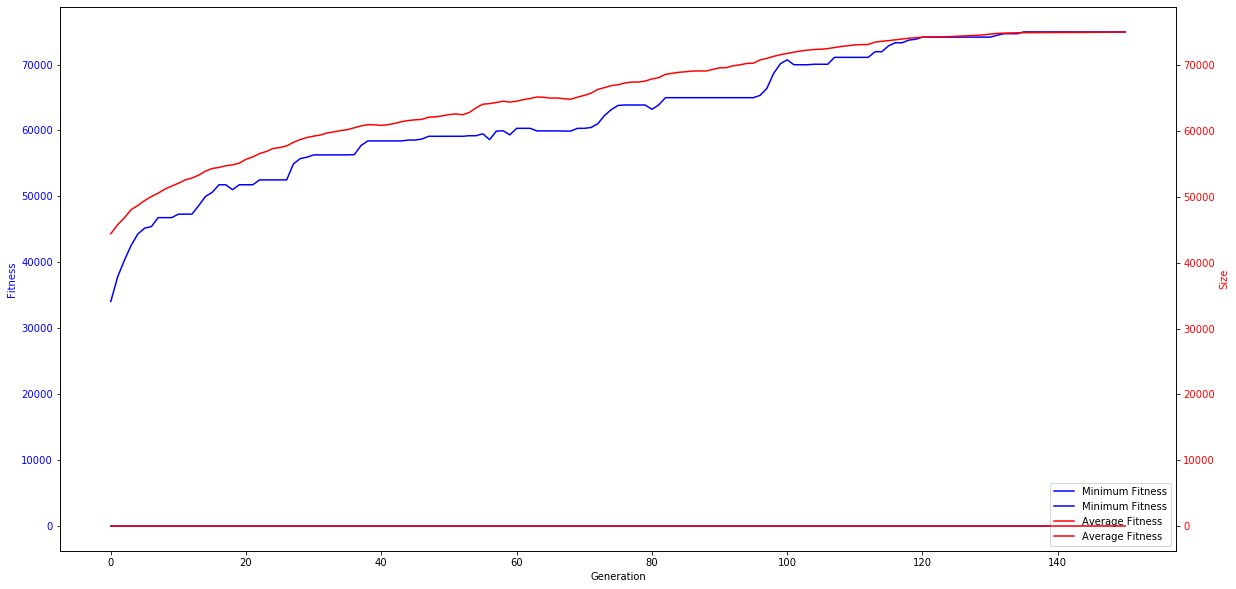

In [26]:
fig, ax1 = plt.subplots(figsize=(20,10))
line1 = ax1.plot(gen, fit_mins, "b-", label="Minimum Fitness")
ax1.set_xlabel("Generation")
ax1.set_ylabel("Fitness", color="b")
for tl in ax1.get_yticklabels():
    tl.set_color("b")

ax2 = ax1.twinx()
line2 = ax2.plot(gen, size_avgs, "r-", label="Average Fitness")
ax2.set_ylabel("Size", color="r")
for tl in ax2.get_yticklabels():
    tl.set_color("r")

lns = line1 + line2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="lower right", frameon=True)

plt.show()

In [27]:
res_df,recall,precision,f1_score, total_rev = evaluate_recommender(dfp_actual,dfp_pred,hof.items[0],3,rev)

In [28]:
f1_score

0.6700507614213197

In [29]:
res_df.Total_Revenue.sum()

75204.0